In [73]:
import sys
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from tsfresh.feature_extraction import extract_features
from multiprocessing import Pool
tqdm.pandas(desc="apply progress")

import warnings
warnings.filterwarnings('ignore')

ver = '1'

In [4]:
# data_dir = "/Users/hidehisa/.kaggle/competitions/plasticc"
data_dir = "../input"
# train = pd.read_csv(data_dir + "/train_with_cluster.csv")
train = pd.read_csv(data_dir + "/training_set.csv")
meta = pd.read_csv(data_dir + "/training_set_metadata.csv")

In [9]:
# nova = [15, 42, 52, 62, 67, 90]
nova = [6, 16, 53, 64, 65, 88, 92, 95]
novaes = meta.query("target == @nova")
train_novae = train.query("object_id in @novaes.object_id")

In [10]:
train_novae.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [11]:
def basic(d):
    df = d.copy()
    df["flux_ratio_sq"] = np.power(df["flux"] / df["flux_err"], 2)
    df["flux_by_flux_ratio_sq"] = df["flux"] * df["flux_ratio_sq"]

    aggs = {
        'flux': ['min', 'max', 'median', 'skew'],
        'detected': ['mean'],
        'flux_ratio_sq': ['sum', 'skew'],
        'flux_by_flux_ratio_sq': ['sum', 'skew'],
    }
    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    agg_df.columns = new_columns
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    
    per_passband_aggs = {
        "flux": ["min", "max", "mean", "std"],
        "flux_ratio_sq": ["sum", "skew"],
        "flux_by_flux_ratio_sq": ["sum", "skew"]
    }
    per_pass_agg_df = df.groupby(["object_id", "passband"]).agg(per_passband_aggs)
    per_pass_agg_df.columns = pd.Index([e[0] + "_" + e[1] for e in per_pass_agg_df.columns])
    per_pass_agg_df["flux_diff"] = per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]
    per_pass_agg_df["flux_diff2"] = (
        per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_mean"]
    per_pass_agg_df["flux_w_mean"] = per_pass_agg_df["flux_by_flux_ratio_sq_sum"] / per_pass_agg_df[
        "flux_ratio_sq_sum"
    ]
    per_pass_agg_df["flux_dif3"] = (
    per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_w_mean"]
    per_pass_agg_df = per_pass_agg_df.unstack()
    per_pass_agg_df.columns = pd.Index([str(e[1]) + "__" + e[0] for e in per_pass_agg_df.columns])
    
    basic_columns = [f"{i}__{j}" for i in range(6) for j in [
        "flux_min",
        "flux_max",
        "flux_mean",
        "flux_std",
        "flux_ratio_sq_sum",
        "flux_ratio_sq_skew",
        "flux_w_mean",
        "flux_diff2"
    ]]
    per_pass_agg_df.drop(basic_columns, axis=1, inplace=True)
    
    agg_df = pd.merge(agg_df, per_pass_agg_df, how="left", on="object_id")
    
    agg_flux_diff = agg_df.reset_index()[["object_id", "flux_diff"]]
    df2 = pd.merge(df, agg_df, how="left", on="object_id")
    df2["flux_norm"] = df2.flux / df2.flux_diff
    del df2["flux"]
    agg_df.drop(["flux_min", "flux_max", "flux_diff"], axis=1, inplace=True)
    
    idxmax_df = df.reset_index().groupby("object_id").agg({"flux": "idxmax"})
    idxmax_df.rename(columns={"flux": "flux_idxmax"}, inplace=True)
    df3 = pd.merge(df, idxmax_df, how="left", on="object_id")
    # 片山変更
    # df3.drop(["cluster", "flux_err", "detected"], axis=1, inplace=True)
    df3.drop(["flux_err", "detected"], axis=1, inplace=True)
    df3["dummy_index"] = df3.index
    df3["index_diff"] = df3.dummy_index - df3.flux_idxmax
    df3 = df3.query("index_diff >= 0 & index_diff < 100")
    df3_mindf = df3.groupby("object_id").agg({
        "flux": "min"
    })
    df3_mindf.rename(columns={"flux": "flux_min"}, inplace=True)
    df3 = pd.merge(df3, df3_mindf, how="left", on="object_id")
    df3["flux"] = df3["flux"] - df3["flux_min"]
    df3["log_flux"] = np.log(df3["flux"] + 0.01)
    fcp = {
        'fft_coefficient': [{
            'coeff': 0,
            'attr': 'abs'
        }, {
            'coeff': 1,
            'attr': 'abs'
        }],
        'kurtosis':
        None,
        'skewness':
        None,
        "cid_ce": [{"normalize": True}]
    }
    fcp2 = {
        "fft_coefficient": [{
            "coeff": 0,
            "attr": "abs"
        }, {
            "coeff": 1,
            "attr": "abs"
        }],
        "abs_energy": None,
        "sample_entropy": None
    }
    fcp3 = {
        "linear_trend": [{
            "attr": "pvalue"
        }, {
            "attr": "intercept"
        }, {
            "attr": "slope"
        }]
    }
    fcp_flux = {
        "longest_strike_above_mean": None,
        "longest_strike_below_mean": None,
        "mean_change": None,
        "mean_abs_change": None,
        "cid_ce": [{"normalize": True}]
    }
    fcp_flux_by_flux_ratio_sq = {
        "longest_strike_above_mean": None,
        "longest_strike_below_mean": None
    }
    agg_df_ts = extract_features(
        df,
        column_id='object_id',
        column_sort='mjd',
        column_kind='passband',
        column_value='flux',
        default_fc_parameters=fcp,
        n_jobs=6)
    agg_df_ts2 = extract_features(
        df2,
        column_id="object_id",
        column_sort="mjd",
        column_kind="passband",
        column_value="flux_norm",
        default_fc_parameters=fcp2,
        n_jobs=4
    )
    agg_df_ts3 = extract_features(
        df3,
        column_id="object_id",
        column_sort="mjd",
        column_kind="passband",
        column_value="log_flux",
        default_fc_parameters=fcp3,
        n_jobs=4
    )
    agg_df_flux = extract_features(
        df,
        column_id="object_id",
        column_value="flux",
        default_fc_parameters=fcp_flux,
        n_jobs=4
    )
    agg_df_ffrs = extract_features(
        df,
        column_id="object_id",
        column_value="flux_by_flux_ratio_sq",
        default_fc_parameters=fcp_flux_by_flux_ratio_sq,
        n_jobs=4
    )
    df_det = df[df['detected'] == 1].copy()

    agg_df_mjd = extract_features(
        df_det,
        column_id='object_id',
        column_value='mjd',
        default_fc_parameters={
            'maximum': None,
            'minimum': None
        },
        n_jobs=8)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd[
        'mjd__minimum']
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts2.columns = pd.Index([e + "_norm" for e in agg_df_ts2.columns])
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd, on='id')
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ts2, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ts3, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_flux, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ffrs, on="id")
    # tsfresh returns a dataframe with an index name='id'
    agg_df_ts.index.rename('object_id', inplace=True)
    agg_df = pd.merge(agg_df, agg_df_ts, on='object_id')
    return agg_df


def cluster_mean_diff(df):
    new_df = df.groupby(["object_id", "cluster"]).agg({
        "flux": ["mean", "max", "min"]
    })
    new_df.columns = pd.Index(
        [e[0] + "_" + e[1] for e in new_df.columns.tolist()])
    new_df["normalized_mean"] = new_df["flux_mean"] / (
        new_df["flux_max"] - new_df["flux_min"])
    new_df.reset_index(inplace=True)
    return new_df.groupby("object_id").agg({"normalized_mean": "std"})


def cluster_mean_diffcluster_mean_diff(df):
    std_df = df.groupby(["object_id", "cluster", "passband"]).agg({
        "flux": "std"
    }).reset_index().groupby(["object_id",
                              "passband"])["flux"].mean().reset_index()
    std_df_max = std_df.groupby("object_id")["flux"].max()
    std_df_min = std_df.groupby("object_id")["flux"].min()
    return (std_df_max / std_df_min).reset_index()


def num_outliers(df):
    new_df = df.groupby("object_id").agg({"flux": ["mean", "std"]})
    new_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_df.columns])
    new_df["upper_sigma"] = new_df["flux_mean"] + new_df["flux_std"]
    new_df["upper_2sigma"] = new_df["flux_mean"] + 2 * new_df["flux_std"]
    new_df["lower_sigma"] = new_df["flux_mean"] - new_df["flux_std"]
    new_df["lower_2sigma"] = new_df["flux_mean"] - 2 * new_df["flux_std"]
    new_df.drop(["flux_mean", "flux_std"], axis=1, inplace=True)
    new_df = pd.merge(df, new_df, how="left", on="object_id")
    new_df["outside_sigma"] = (
        (new_df["flux"] > new_df["upper_sigma"]) |
        (new_df["flux"] < new_df["lower_sigma"])).astype(int)
    new_df["outside_2sigma"] = (
        (new_df["flux"] > new_df["upper_2sigma"]) |
        (new_df["flux"] < new_df["lower_2sigma"])).astype(int)

    return_df = new_df.groupby("object_id").agg({
        "outside_sigma": "sum",
        "outside_2sigma": "sum"
    })
    return_df.reset_index(inplace=True)
    return return_df

In [12]:
def haversine_plus(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees) from 
    #https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),  
                          np.multiply(np.cos(lat1), 
                                      np.multiply(np.cos(lat2), 
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))
    
    haversine = np.multiply(2, np.arcsin(np.sqrt(a)))
    return {
        'haversine': haversine, 
        'latlon1': np.subtract(np.multiply(lon1, lat1), np.multiply(lon2, lat2)), 
   }


def process_meta(meta_df):
    meta_dict = dict()
    # distance
    meta_dict.update(haversine_plus(meta_df['ra'].values, meta_df['decl'].values, 
                   meta_df['gal_l'].values, meta_df['gal_b'].values))
    #
    meta_dict['hostgal_photoz_certain'] = np.multiply(
            meta_df['hostgal_photoz'].values, 
             np.exp(meta_df['hostgal_photoz_err'].values))
    
    meta_df = pd.concat([meta_df, pd.DataFrame(meta_dict, index=meta_df.index)], axis=1)
    return meta_df


def add_rank_bottom_and_top(df, feature_name):
    objid = ["object_id"]
    columns = [f"{i}{feature_name}" for i in range(6)]
    partial = df[objid+columns]
    partial_values = partial.melt(id_vars=objid, value_vars=columns).sort_values(["object_id", "value"])
    
    top_and_bottom = partial_values.groupby("object_id").agg({
        "variable": ["first", "last"]
    })
    top_and_bottom.columns = ["top"+feature_name, "bottom"+feature_name]
    for i, n in zip(["0", "1", "2", "3", "4", "5"], columns):
        top_and_bottom = top_and_bottom.replace(n, i)
    top_and_bottom = top_and_bottom.astype(int)
    return top_and_bottom



def rank(df, feature_name, thres=20):
    objid = ["object_id"]
    columns = [f"{i}{feature_name}" for i in range(6)]
    partial = df[objid+columns]
    partial_values = partial.melt(id_vars=objid, value_vars=columns).sort_values(["object_id", "value"])
    for i, n in zip(["0", "1", "2", "3", "4", "5"], columns):
        partial_values.replace(n, i, inplace=True)
    partial_values["dummy"] = 1
    rank_feats = partial_values.groupby(["object_id", "dummy"]).agg({
        "variable": "sum"
    })
    d = dict()
    cnt = 0
    for i in rank_feats["variable"]:
        if i not in d.keys():
            d[i] = cnt
            cnt += 1
    rank_feats.reset_index(inplace=True)
    rank_feats.drop("dummy", axis=1, inplace=True)
    rank_feats.rename(columns={"variable": f"rank{feature_name}"}, inplace=True)
    rank_feats[f"rank{feature_name}"].replace(d, inplace=True)
    rank_dict = (rank_feats[f"rank{feature_name}"].value_counts() > thres).to_dict()
    rank_feats[f"rank{feature_name}"] = rank_feats[f"rank{feature_name}"].map(
        lambda x: x if rank_dict[x] else cnt+1
    )
    
    return rank_feats



def add_by_features(df, feature_name, new_feat_name):
    for i in range(5):
        for j in range(1, 6):
            if j > i:
                df[f"{new_feat_name}{j}_by_{i}"] = df[f"{j}{feature_name}"] / df[f"{i}{feature_name}"]
    return df


In [13]:
def add_per_passband(d):
    df = d.copy()
    df["flux_ratio_sq"] = np.power(df["flux"] / df["flux_err"], 2)
    df["flux_by_flux_ratio_sq"] = df["flux"] * df["flux_ratio_sq"]
    per_passband_aggs = {
        "flux": ["min", "max", "mean", "std"],
        "flux_ratio_sq": ["sum", "skew"],
        "flux_by_flux_ratio_sq": ["sum", "skew"]
    }
    per_pass_agg_df = df.groupby(["object_id", "passband"]).agg(per_passband_aggs)
    per_pass_agg_df.columns = pd.Index([e[0] + "_" + e[1] for e in per_pass_agg_df.columns])
    per_pass_agg_df["flux_diff"] = per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]
    per_pass_agg_df["flux_diff2"] = (
        per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_mean"]
    per_pass_agg_df["flux_w_mean"] = per_pass_agg_df["flux_by_flux_ratio_sq_sum"] / per_pass_agg_df[
        "flux_ratio_sq_sum"
    ]
    per_pass_agg_df["flux_dif3"] = (
    per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_w_mean"]
    per_pass_agg_df = per_pass_agg_df.unstack()
    per_pass_agg_df.columns = pd.Index([str(e[1]) + "__" + e[0] for e in per_pass_agg_df.columns])
    basic_columns = [f"{i}__{j}" for i in range(6) for j in [
        "flux_min",
        "flux_max",
        "flux_mean",
        "flux_std",
        "flux_ratio_sq_sum",
        "flux_ratio_sq_skew",
        "flux_w_mean",
        "flux_diff2"
    ]]
    per_pass_agg_df.drop(basic_columns, axis=1, inplace=True)
    return per_pass_agg_df

In [14]:
def get_full(df, meta):
    agg_basic = basic(df)
    # 片山変更
    # cl_mean_diff = cluster_mean_diff(df)
    # ps_std_diff = passband_std_difference(df)
    num_out = num_outliers(df)
    
    # 片山変更
    full = agg_basic
    # full = pd.merge(agg_basic, cl_mean_diff, how="left", on="object_id")
    # full = pd.merge(full, ps_std_diff, how="left", on="object_id")
    full = pd.merge(full, num_out, how="left", on="object_id")
    meta = process_meta(meta)
    full = pd.merge(full, meta, how="left", on="object_id")
    
    add_by_features(full, "__abs_energy_norm", "abs_energy")
    add_by_features(full, "__flux_diff", "flux_diff")
    add_by_features(full, "__flux_dif3", "flux_dif3")
    add_by_features(full, "__flux_by_flux_ratio_sq_sum", "flux_by_flux_ratio_sq_sum")
    add_by_features(full, "__fft_coefficient__coeff_0__attr_\"abs\"_norm", "fft")
    add_by_features(full, "__linear_trend__attr_\"pvalue\"", "linear_p")
    add_by_features(full, "__linear_trend__attr_\"intercept\"", "linear_i")
    add_by_features(full, "__linear_trend__attr_\"slope\"", "linear_s")
    
    abs_energy = add_rank_bottom_and_top(full, "__abs_energy_norm")
    rank_abs_energy = rank(full, "__abs_energy_norm", 70)

    flux_diff = add_rank_bottom_and_top(full, "__flux_diff")
    rank_flux_diff = rank(full, "__flux_diff", 70)

    flux_dif3 = add_rank_bottom_and_top(full, "__flux_dif3")
    rank_flux_dif3 = rank(full, "__flux_dif3", 70)

    flux_by_flux_ratio_sq_sum = add_rank_bottom_and_top(full, "__flux_by_flux_ratio_sq_sum")
    rank_flux_by_flux_ratio_sq_sum = rank(full, "__flux_by_flux_ratio_sq_sum", 70)
    
    fc = add_rank_bottom_and_top(full, "__fft_coefficient__coeff_0__attr_\"abs\"_norm")
    rank_fc = rank(full, "__fft_coefficient__coeff_0__attr_\"abs\"_norm", 70)
    
    linear_p = add_rank_bottom_and_top(full, "__linear_trend__attr_\"pvalue\"")
    rank_linear_p = rank(full, "__linear_trend__attr_\"pvalue\"", 70)
    
    linear_i = add_rank_bottom_and_top(full, "__linear_trend__attr_\"intercept\"")
    rank_linear_i = rank(full, "__linear_trend__attr_\"intercept\"", 70)
    
    linear_s = add_rank_bottom_and_top(full, "__linear_trend__attr_\"slope\"")
    rank_linear_s = rank(full, "__linear_trend__attr_\"slope\"", 70)
    full = pd.merge(full, rank_abs_energy, how="left", on="object_id")
    full = pd.merge(full, rank_flux_diff, how="left", on="object_id")
    full = pd.merge(full, rank_flux_dif3, how="left", on="object_id")
    full = pd.merge(full, abs_energy, how="left", on="object_id")
    full = pd.merge(full, flux_diff, how="left", on="object_id")
    full = pd.merge(full, flux_dif3, how="left", on="object_id")
    full = pd.merge(full, flux_by_flux_ratio_sq_sum, how="left", on="object_id")
    full = pd.merge(full, rank_flux_by_flux_ratio_sq_sum, how="left", on="object_id")
    full = pd.merge(full, fc, how="left", on="object_id")
    full = pd.merge(full, rank_fc, how="left", on="object_id")
    full = pd.merge(full, linear_p, how="left", on="object_id")
    full = pd.merge(full, rank_linear_p, how="left", on="object_id")
    full = pd.merge(full, linear_i, how="left", on="object_id")
    full = pd.merge(full, rank_linear_i, how="left", on="object_id")
    full = pd.merge(full, linear_s, how="left", on="object_id")
    full = pd.merge(full, rank_linear_s, how="left", on="object_id")
    if "target" in full.columns:
        full.drop("target", axis=1, inplace=True)
    return full


def train_data(df, meta):
    full = get_full(df, meta)
    y = meta.target
    classes = sorted(y.unique())
    class_weight = {c: 1 for c in classes}

    for c in [15]:
        class_weight[c] = 2
    oof_df = full[["object_id"]]
    del full['object_id'], full['distmod'], full['hostgal_specz']
    del full['ra'], full['decl'], full['gal_l'], full['gal_b'], full['ddf']
    return full, y, classes, class_weight, oof_df

In [15]:
%%time
full, y, classes, class_weight, oof_df = train_data(train_novae, novaes)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.70it/s]


Wall time: 1min 18s


In [16]:
classes

[6, 16, 53, 64, 65, 88, 92, 95]

In [17]:
class_weight

{6: 1, 16: 1, 53: 1, 64: 1, 65: 1, 88: 1, 92: 1, 95: 1, 15: 2}

In [18]:
train_mean = full.mean(axis=0)
full.replace([np.inf, -np.inf], np.nan, inplace=True)
full.fillna(0, inplace=True)
full.head()

,flux_median,flux_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,0__flux_by_flux_ratio_sq_sum,1__flux_by_flux_ratio_sq_sum,2__flux_by_flux_ratio_sq_sum,...,"rank__fft_coefficient__coeff_0__attr_""abs""_norm","top__linear_trend__attr_""pvalue""","bottom__linear_trend__attr_""pvalue""","rank__linear_trend__attr_""pvalue""","top__linear_trend__attr_""intercept""","bottom__linear_trend__attr_""intercept""","rank__linear_trend__attr_""intercept""","top__linear_trend__attr_""slope""","bottom__linear_trend__attr_""slope""","rank__linear_trend__attr_""slope"""
0,-89.477524,-0.349540,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,-626381.909593,-5.626857e+08,-2.058831e+08,...,596,0,1,697,1,0,661,0,1,677
1,-0.873033,0.014989,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,-5916.693412,-8.363832e+03,-6.553036e+03,...,596,1,5,697,0,5,661,5,0,677
2,0.208109,9.125056,0.009091,1.319268e+03,18.061052,6.502524e+04,18.163484,64306.074322,2.897663e+02,-1.566689e+01,...,596,4,5,697,5,0,661,0,5,677
3,0.166696,-1.709852,0.011765,1.205968e+03,11.285193,2.755184e+04,11.510411,208.352350,-3.278879e+00,2.753832e+04,...,596,2,4,697,5,2,661,5,0,677
4,0.023840,17.217450,0.025568,3.546545e+04,18.608142,5.763102e+07,18.759666,168177.965325,9.548800e+03,4.523659e+04,...,596,5,2,697,2,5,661,5,2,677


In [28]:
classes

[6, 16, 53, 64, 65, 88, 92, 95]

In [32]:
def multi_weighted_logloss_novae(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 16, 53, 64, 65, 88, 92, 95]
    class_weight = {6: 1, 16: 1, 53: 1, 64: 2, 65: 1, 88: 1, 92: 1, 95: 1}
    
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss_novae(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 16, 53, 64, 65, 88, 92, 95]
    class_weight = {6: 1, 16: 1, 53: 1, 64: 2, 65: 1, 88: 1, 92: 1, 95: 1}
    
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [33]:
def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 12))
    sns.barplot(
        x='gain',
        y='feature',
        data=importances_.sort_values('mean_gain', ascending=False)[:300])
    plt.tight_layout()
    plt.savefig('importances_novae.png')


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def save_cm(y, oof_preds):
    unique_y = np.unique(y)
    class_map = dict()
    for i, val in enumerate(unique_y):
        class_map[val] = i

    y_map = np.zeros((y.shape[0], ))
    y_map = np.array([class_map[val] for val in y])

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds, axis=-1))
    np.set_printoptions(precision=2)

    class_names = ["class_15", "class_42", "class_52", "class_62", "class_67", "class_90"]
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(12, 12))
    plot_confusion_matrix(
        cnf_matrix,
        classes=class_names,
        normalize=True,
        title='Confusion matrix')
    plt.savefig("confusion_matrix_novae.png")

In [21]:
def smoteAdataset(Xig_train, yig_train, Xig_test, yig_test):     
    sm=SMOTE(random_state=2)
    Xig_train_res, yig_train_res = sm.fit_sample(Xig_train, yig_train.ravel())
    return Xig_train_res, pd.Series(yig_train_res), Xig_test, pd.Series(yig_test)

In [58]:
def lgbm_modeling_cross_validation(params,
                                   full_train, 
                                   y, 
                                   classes, 
                                   class_weights, 
                                   nr_fold=12, 
                                   random_state=1, 
                                   save_plot=True, 
                                   show_log=True):

    # Compute weights
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
   # print(weights)
   # weights=class_weights
    clfs = []
    importances = pd.DataFrame()
    folds = StratifiedKFold(n_splits=nr_fold, 
                            shuffle=True, 
                            random_state=random_state)
    
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]
        
                
        trn_xa, trn_y, val_xa, val_y=smoteAdataset(trn_x.values, trn_y.values, val_x.values, val_y.values)
        trn_x=pd.DataFrame(data=trn_xa, columns=trn_x.columns)
    
        val_x=pd.DataFrame(data=val_xa, columns=val_x.columns)
        
        
        categorical_feature = [
            "rank__abs_energy_norm", "rank__flux_diff", "rank__flux_dif3", "rank__flux_by_flux_ratio_sq_sum",
            "rank__fft_coefficient__coeff_0__attr_\"abs\"_norm", "rank__linear_trend__attr_\"pvalue\"", 
            "rank__linear_trend__attr_\"intercept\"", "rank__linear_trend__attr_\"slope\""
            ]
        categorical_feature = list(set(categorical_feature) & set(full_train.columns))
        
        
        clf = lgb.LGBMClassifier(**params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss_novae,
            verbose=100,
            early_stopping_rounds=50,
            sample_weight=trn_y.map(weights),
            categorical_feature=categorical_feature
        )
        clfs.append(clf)

        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        
        if show_log:
            print('no {}-fold loss: {}'.format(fold_ + 1, 
                  multi_weighted_logloss_novae(val_y, oof_preds[val_, :])))
    
        imp_df = pd.DataFrame({
                'feature': full_train.columns,
                'gain': clf.feature_importances_,
                'fold': [fold_ + 1] * len(full_train.columns),
                })
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

    score = multi_weighted_logloss_novae(y_true=y, y_preds=oof_preds)
    print('MULTI WEIGHTED LOG LOSS: {:.5f}'.format(score))
    
    if save_plot:
        df_importances = save_importances(importances_=importances)
    
    return clfs, score, oof_preds

In [55]:
def plot_importances(clfs, features):
    importances = []
    for clf in clfs:
        importances.append(clf.feature_importances_)
    importances = pd.Series(np.array(importances).mean(axis=0), index=features)
    importances = importances.sort_values(ascending=False)

    fig, ax = plt.subplots(1,1,figsize=(14,14))
    importances.iloc[:40].plot(kind='barh', ax=ax)
    fig.tight_layout()

    return importances

In [23]:
lgb_params = {
        'device': 'cpu', 
        'objective': 'binary',  
        'boosting_type': 'gbdt', 
        'n_jobs': -1, 
        'max_depth': 7, 
        'n_estimators': 500, 
        'subsample_freq': 2, 
        'subsample_for_bin': 5000, 
        'min_data_per_group': 100, 
        'max_cat_to_onehot': 4, 
        'cat_l2': 1.0, 
        'cat_smooth': 59.5, 
        'max_cat_threshold': 32, 
        'metric_freq': 10, 
        'verbosity': -1, 
        'metric': 'binary', 
        'xgboost_dart_mode': False, 
        'uniform_drop': False, 
        'colsample_bytree': 0.5, 
        'drop_rate': 0.173, 
        'learning_rate': 0.0267, 
        'max_drop': 5, 
        'min_child_samples': 10, 
        'min_child_weight': 100.0, 
        'min_split_gain': 0.1, 
        'num_leaves': 7, 
        'reg_alpha': 0.1, 
        'reg_lambda': 0.00023, 
        'skip_drop': 0.44, 
        'subsample': 0.75
    }

novae_params = {
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 5, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 4,
    'n_estimators': 500,
    'num_leaves': 6,
    'learning_rate': 0.11,
    'drop_rate': 0.08,
    'subsample': 0.75,
    'subsample_freq': 2,
    'min_split_gain': 0.1,
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5
}

C:\Anaconda3_4.4.0\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Anaconda3_4.4.0\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.000236946	training's wloss: 0.000823577	valid_1's multi_logloss: 0.0369706	valid_1's wloss: 0.0876297
Early stopping, best iteration is:
[77]	training's multi_logloss: 0.00104175	training's wloss: 0.00320991	valid_1's multi_logloss: 0.0480897	valid_1's wloss: 0.0681127
no 1-fold loss: 0.0681127106739844


C:\Anaconda3_4.4.0\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Anaconda3_4.4.0\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.000211481	training's wloss: 0.000740396	valid_1's multi_logloss: 0.0733026	valid_1's wloss: 0.108987
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.000607319	training's wloss: 0.00194304	valid_1's multi_logloss: 0.075851	valid_1's wloss: 0.103153
no 2-fold loss: 0.10315254850553687


C:\Anaconda3_4.4.0\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Anaconda3_4.4.0\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.00019022	training's wloss: 0.000641011	valid_1's multi_logloss: 0.074419	valid_1's wloss: 0.106606
Early stopping, best iteration is:
[77]	training's multi_logloss: 0.000895404	training's wloss: 0.00264761	valid_1's multi_logloss: 0.0815047	valid_1's wloss: 0.101608
no 3-fold loss: 0.10160780639150316


C:\Anaconda3_4.4.0\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Anaconda3_4.4.0\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.000234494	training's wloss: 0.000836135	valid_1's multi_logloss: 0.027294	valid_1's wloss: 0.0344645
Early stopping, best iteration is:
[142]	training's multi_logloss: 4.45669e-05	training's wloss: 0.000159328	valid_1's multi_logloss: 0.0213292	valid_1's wloss: 0.0325258
no 4-fold loss: 0.03252578113430463


C:\Anaconda3_4.4.0\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Anaconda3_4.4.0\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.000229529	training's wloss: 0.000801816	valid_1's multi_logloss: 0.040513	valid_1's wloss: 0.0605923
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.000190849	training's wloss: 0.000666519	valid_1's multi_logloss: 0.0393844	valid_1's wloss: 0.0581562
no 5-fold loss: 0.05815624341905566
MULTI WEIGHTED LOG LOSS: 0.07267


C:\Anaconda3_4.4.0\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


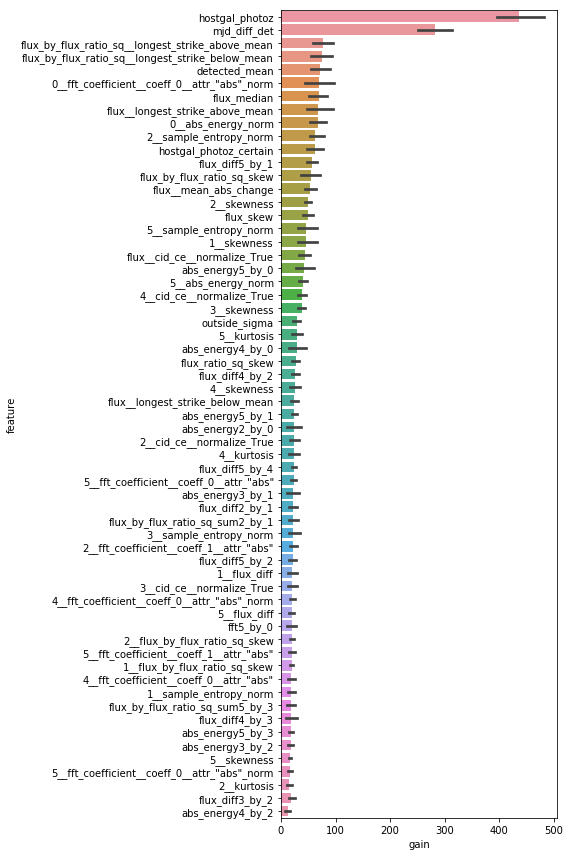

In [35]:
for cindex in full.columns:
    full.loc[:,cindex]=np.float64(full.loc[:,cindex])
clfs, score, oof_df = lgbm_modeling_cross_validation(
    novae_params, 
    full, 
    y, 
    classes,
    class_weight,
    5,
    7)

In [39]:
print('チューニング前のscore')
print(score)

チューニング前のscore
0.07267172494109933


In [ ]:
def plot_importances(clfs, features):
    importances = []
    for clf in clfs:
        importances.append(clf.feature_importances_)
    importances = pd.Series(np.array(importances).mean(axis=0), index=features)
    importances = importances.sort_values(ascending=False)

    fig, ax = plt.subplots(1,1,figsize=(14,14))
    importances.iloc[:40].plot(kind='barh', ax=ax)
    fig.tight_layout()

    return importances

Normalized confusion matrix


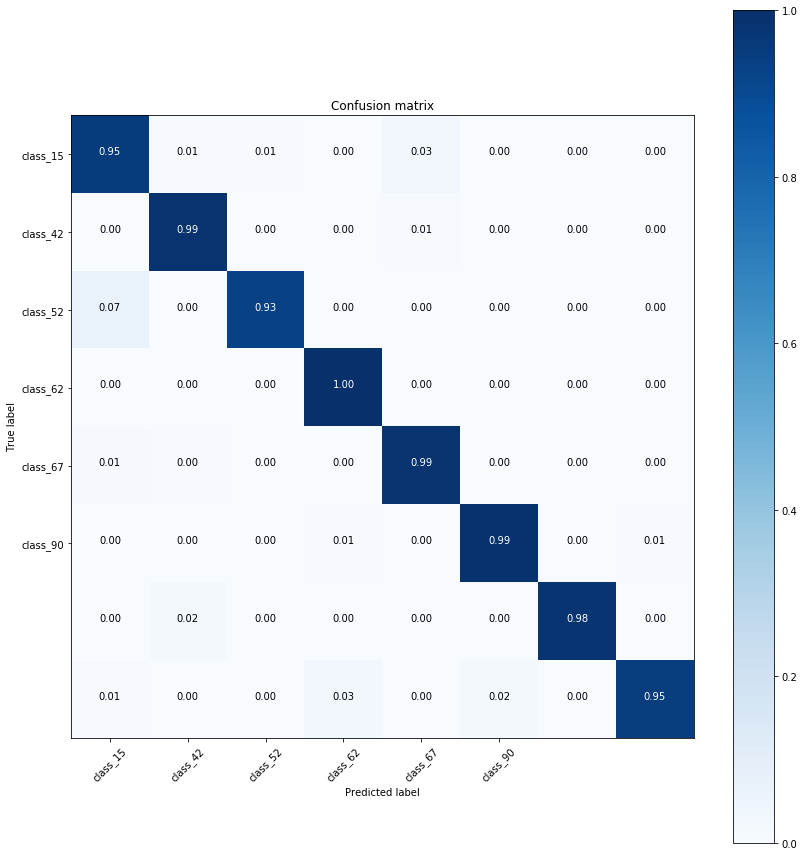

In [36]:
save_cm(y, oof_df)

In [46]:
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize
from skopt.space import Real, Integer
from functools import partial, wraps
import gc; gc.enable()

def tune_lgbm_paramters(X, y, classes, class_weights, n_calls):
    def objective(X, y, classes, class_weights, values):
        params = {
            'learning_rate': values[0],
            'min_child_weight': values[1], 
            'max_depth': values[2], 
            'colsample_bytree': values[3], 
            'subsample': values[4], 
            'reg_lambda': values[5], 
            'subsample_freq': values[6], 
            'subsample_for_bin': values[7], 
            'min_data_per_group': values[8], 
            'max_cat_to_onehot': values[9], 
            'cat_l2': values[10], 
            'cat_smooth': values[11], 
            'max_cat_threshold': values[12], 
            'metric_freq': values[13], 
            'drop_rate': values[14], 
            'max_drop': values[15], 
            'min_child_samples': values[16], 
            'min_split_gain': values[17], 
            'num_leaves': values[18], 
            'reg_alpha': values[19], 
            'skip_drop': values[20], 
            # 固定
            'device': 'cpu', 
            'objective': 'multiclass',  
            'boosting_type': 'gbdt', 
            'n_jobs': -1, 
            'xgboost_dart_mode': False, 
            'uniform_drop': False, 
            'verbosity': -1, 
            'metric': 'multi_logloss', 
            'n_estimators': 500,
        }

        _, score, _ = lgbm_modeling_cross_validation(params, 
                                                     X, 
                                                     y, 
                                                     classes, 
                                                     class_weights, 
                                                     nr_fold=3, 
                                                     random_state=7, 
                                                     save_plot=False, 
                                                     show_log=False)
        
        gc.collect()

        return score

    space  = [
        Real(0.01, 1.0, name='learning_rate'),
        Integer(10, 100, name='min_child_weight'),
        Integer(3, 50, name='max_depth'),
        Real(0.01, 1.0, name='colsample_bytree'),
        Real(0.01, 1.0, name='subsample'),
        Real(1e-9, 1000, name='reg_lambda'),
        Integer(0, 5, name='subsample_freq'),
        Integer(100, 6000, name='subsample_for_bin'),
        Integer(10, 2000, name='min_data_per_group'),
        Integer(1, 10, name='max_cat_to_onehot'),
        Real(1e-9, 2.0, name='cat_l2'),
        Real(10, 100, name='cat_smooth'),
        Integer(4, 64, name='max_cat_threshold'),
        Integer(1, 10, name='metric_freq'),
        Real(1e-9, 1.0, name='drop_rate'),
        Integer(0, 10, name='max_drop'),
        Integer(3, 30, name='min_child_samples'),
        Real(1e-9, 1.0, name='min_split_gain'),
        Integer(3, 15, name='num_leaves'),
        Real(1e-9, 1.0, name='reg_alpha'),
        Real(1e-9, 1.0, name='skip_drop'),
    ]

    objective = partial(objective, X, y, classes, class_weights)
    res_gp = gp_minimize(objective, space, n_calls=n_calls, random_state=0, n_random_starts=10)

    
    best_params = {
        'learning_rate': res_gp.x[0],
        'min_child_weight': res_gp.x[1], 
        'max_depth': res_gp.x[2], 
        'colsample_bytree': res_gp.x[3], 
        'subsample': res_gp.x[4], 
        'reg_lambda': res_gp.x[5], 
        'subsample_freq': res_gp.x[6], 
        'subsample_for_bin': res_gp.x[7], 
        'min_data_per_group': res_gp.x[8], 
        'max_cat_to_onehot': res_gp.x[9], 
        'cat_l2': res_gp.x[10], 
        'cat_smooth': res_gp.x[11], 
        'max_cat_threshold': res_gp.x[12], 
        'metric_freq': res_gp.x[13], 
        'drop_rate': res_gp.x[14], 
        'max_drop': res_gp.x[15], 
        'min_child_samples': res_gp.x[16], 
        'min_split_gain': res_gp.x[17], 
        'num_leaves': res_gp.x[18], 
        'reg_alpha': res_gp.x[19], 
        'skip_drop': res_gp.x[20], 
        # 固定
        'device': 'cpu', 
        'objective': 'multiclass',  
        'boosting_type': 'gbdt', 
        'n_jobs': -1, 
        'xgboost_dart_mode': False, 
        'uniform_drop': False, 
        'metric': 'multi_logloss', 
        'n_estimators': 500,
    }

    return best_params


In [47]:
%%time
best_params = tune_lgbm_paramters(full, y, classes, class_weight, 40)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.00503894	training's wloss: 0.0158716	valid_1's multi_logloss: 0.0860136	valid_1's wloss: 0.0848618
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.00501846	training's wloss: 0.0158314	valid_1's multi_logloss: 0.0858058	valid_1's wloss: 0.0845615
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.00507873	training's wloss: 0.0159928	valid_1's multi_logloss: 0.0853167	valid_1's wloss: 0.093939
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.00507873	training's wloss: 0.0159928	valid_1's multi_logloss: 0.0853167	valid_1's wloss: 0.093939
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.00507844	training's wloss: 0.0163912	valid_1's multi_logloss: 0.0817643	valid_1's wloss: 0.0902087
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.00489559	trai

[100]	training's multi_logloss: 0.0023796	training's wloss: 0.00772433	valid_1's multi_logloss: 0.0831489	valid_1's wloss: 0.106819
Early stopping, best iteration is:
[50]	training's multi_logloss: 0.0023796	training's wloss: 0.00772433	valid_1's multi_logloss: 0.0831489	valid_1's wloss: 0.106819
MULTI WEIGHTED LOG LOSS: 0.09455
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.00543933	training's wloss: 0.0177737	valid_1's multi_logloss: 0.0996753	valid_1's wloss: 0.0964121
[200]	training's multi_logloss: 0.00442928	training's wloss: 0.0138587	valid_1's multi_logloss: 0.0886349	valid_1's wloss: 0.0917645
Early stopping, best iteration is:
[234]	training's multi_logloss: 0.00433292	training's wloss: 0.013626	valid_1's multi_logloss: 0.0875923	valid_1's wloss: 0.0909476
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.00540962	training's wloss: 0.0174288	valid_1's multi_logloss: 0.0888933	valid_

[23]	training's multi_logloss: 0.00138197	training's wloss: 0.00488142	valid_1's multi_logloss: 0.0850285	valid_1's wloss: 0.089688
MULTI WEIGHTED LOG LOSS: 0.11381
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.0194729	training's wloss: 0.0601047	valid_1's multi_logloss: 0.188832	valid_1's wloss: 0.127585
[200]	training's multi_logloss: 0.00887818	training's wloss: 0.028734	valid_1's multi_logloss: 0.119072	valid_1's wloss: 0.0997411
[300]	training's multi_logloss: 0.00626514	training's wloss: 0.0202219	valid_1's multi_logloss: 0.0985678	valid_1's wloss: 0.0918151
[400]	training's multi_logloss: 0.00512675	training's wloss: 0.0165614	valid_1's multi_logloss: 0.0898824	valid_1's wloss: 0.0879875
[500]	training's multi_logloss: 0.00452316	training's wloss: 0.0146106	valid_1's multi_logloss: 0.0845847	valid_1's wloss: 0.0852445
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.00452316	training's wloss: 0.01

[65]	training's multi_logloss: 0.0031288	training's wloss: 0.0100844	valid_1's multi_logloss: 0.107711	valid_1's wloss: 0.101304
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.00320217	training's wloss: 0.0101534	valid_1's multi_logloss: 0.0719422	valid_1's wloss: 0.0777389
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.00301582	training's wloss: 0.00949352	valid_1's multi_logloss: 0.070376	valid_1's wloss: 0.0700883
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.00303697	training's wloss: 0.00954715	valid_1's multi_logloss: 0.0704728	valid_1's wloss: 0.070052
MULTI WEIGHTED LOG LOSS: 0.08310
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.548269	training's wloss: 0.904001	valid_1's multi_logloss: 1.32481	valid_1's wloss: 0.952014
[200]	training's multi_logloss: 0.252656	training's wloss:

[100]	training's multi_logloss: 0.00197353	training's wloss: 0.00654456	valid_1's multi_logloss: 0.0581924	valid_1's wloss: 0.0742368
[200]	training's multi_logloss: 0.00109957	training's wloss: 0.00366341	valid_1's multi_logloss: 0.0486936	valid_1's wloss: 0.0671839
[300]	training's multi_logloss: 0.000814564	training's wloss: 0.00269262	valid_1's multi_logloss: 0.0453375	valid_1's wloss: 0.0649354
[400]	training's multi_logloss: 0.000683274	training's wloss: 0.00223746	valid_1's multi_logloss: 0.0435127	valid_1's wloss: 0.0637058
[500]	training's multi_logloss: 0.000603968	training's wloss: 0.0019659	valid_1's multi_logloss: 0.0426201	valid_1's wloss: 0.0630989
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.000603968	training's wloss: 0.0019659	valid_1's multi_logloss: 0.0426201	valid_1's wloss: 0.0630989
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.002062	training's wloss: 0.00700049	valid_1's mult

[500]	training's multi_logloss: 0.00209459	training's wloss: 0.00692319	valid_1's multi_logloss: 0.0762631	valid_1's wloss: 0.0707258
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.00727311	training's wloss: 0.0250695	valid_1's multi_logloss: 0.0993099	valid_1's wloss: 0.0860154
[200]	training's multi_logloss: 0.00355991	training's wloss: 0.0119038	valid_1's multi_logloss: 0.0658798	valid_1's wloss: 0.0679402
[300]	training's multi_logloss: 0.00264186	training's wloss: 0.00871888	valid_1's multi_logloss: 0.0578022	valid_1's wloss: 0.0641345
[400]	training's multi_logloss: 0.00226406	training's wloss: 0.00741658	valid_1's multi_logloss: 0.0547297	valid_1's wloss: 0.062504
[500]	training's multi_logloss: 0.00206788	training's wloss: 0.00672	valid_1's multi_logloss: 0.053133	valid_1's wloss: 0.0619994
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.00206788	training's wloss: 0.00672	valid_1's multi_logloss:

[41]	training's multi_logloss: 0.00609451	training's wloss: 0.0203907	valid_1's multi_logloss: 0.0908898	valid_1's wloss: 0.0988388
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.00517426	training's wloss: 0.0172825	valid_1's multi_logloss: 0.0935474	valid_1's wloss: 0.118325
Early stopping, best iteration is:
[58]	training's multi_logloss: 0.00517426	training's wloss: 0.0172825	valid_1's multi_logloss: 0.0935474	valid_1's wloss: 0.118325
MULTI WEIGHTED LOG LOSS: 0.10818
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.458936	training's wloss: 0.723687	valid_1's multi_logloss: 1.05495	valid_1's wloss: 0.812579
[200]	training's multi_logloss: 0.176576	training's wloss: 0.305083	valid_1's multi_logloss: 0.555491	valid_1's wloss: 0.406937
[300]	training's multi_logloss: 0.073593	training's wloss: 0.141415	valid_1's multi_logloss: 0.32903	valid_1's wloss: 0.238398
[400]	training's multi_logloss:

[300]	training's multi_logloss: 0.482754	training's wloss: 1.06774	valid_1's multi_logloss: 1.97102	valid_1's wloss: 1.21753
[400]	training's multi_logloss: 0.372976	training's wloss: 0.871655	valid_1's multi_logloss: 1.68928	valid_1's wloss: 1.03318
[500]	training's multi_logloss: 0.296804	training's wloss: 0.727178	valid_1's multi_logloss: 1.47035	valid_1's wloss: 0.896988
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.296804	training's wloss: 0.727178	valid_1's multi_logloss: 1.47035	valid_1's wloss: 0.896988
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.965833	training's wloss: 1.81465	valid_1's multi_logloss: 2.86212	valid_1's wloss: 1.89858
[200]	training's multi_logloss: 0.666763	training's wloss: 1.37469	valid_1's multi_logloss: 2.3831	valid_1's wloss: 1.50268
[300]	training's multi_logloss: 0.484964	training's wloss: 1.07617	valid_1's multi_logloss: 1.99881	valid_1's wloss: 1.22288
[400]	train

[300]	training's multi_logloss: 0.00247461	training's wloss: 0.0076818	valid_1's multi_logloss: 0.0587152	valid_1's wloss: 0.0618505
[400]	training's multi_logloss: 0.00185394	training's wloss: 0.0058793	valid_1's multi_logloss: 0.053801	valid_1's wloss: 0.0595355
[500]	training's multi_logloss: 0.00168489	training's wloss: 0.00548948	valid_1's multi_logloss: 0.05289	valid_1's wloss: 0.0591022
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.00168489	training's wloss: 0.00548948	valid_1's multi_logloss: 0.05289	valid_1's wloss: 0.0591022
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.0328672	training's wloss: 0.0772411	valid_1's multi_logloss: 0.212142	valid_1's wloss: 0.156569
[200]	training's multi_logloss: 0.00516777	training's wloss: 0.0155599	valid_1's multi_logloss: 0.0798101	valid_1's wloss: 0.0750015
[300]	training's multi_logloss: 0.0025694	training's wloss: 0.00815334	valid_1's multi_logloss: 0.

In [48]:
import pickle
with open('./non_novae_bestmodel.pickle', mode='wb') as f:
    pickle.dump(best_params, f)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.0324557	training's wloss: 0.0734524	valid_1's multi_logloss: 0.220651	valid_1's wloss: 0.14628
[200]	training's multi_logloss: 0.00485148	training's wloss: 0.0142098	valid_1's multi_logloss: 0.079317	valid_1's wloss: 0.0627094
[300]	training's multi_logloss: 0.0023294	training's wloss: 0.00736372	valid_1's multi_logloss: 0.0571649	valid_1's wloss: 0.0537075
[400]	training's multi_logloss: 0.00172036	training's wloss: 0.00556349	valid_1's multi_logloss: 0.0497181	valid_1's wloss: 0.0523852
Early stopping, best iteration is:
[367]	training's multi_logloss: 0.00185178	training's wloss: 0.00594586	valid_1's multi_logloss: 0.0512155	valid_1's wloss: 0.0522225
no 1-fold loss: 0.05222249741707721
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.0324796	training's wloss: 0.0736845	valid_1's multi_logloss: 0.197494	valid_1's wloss: 0.16036
[200]	training

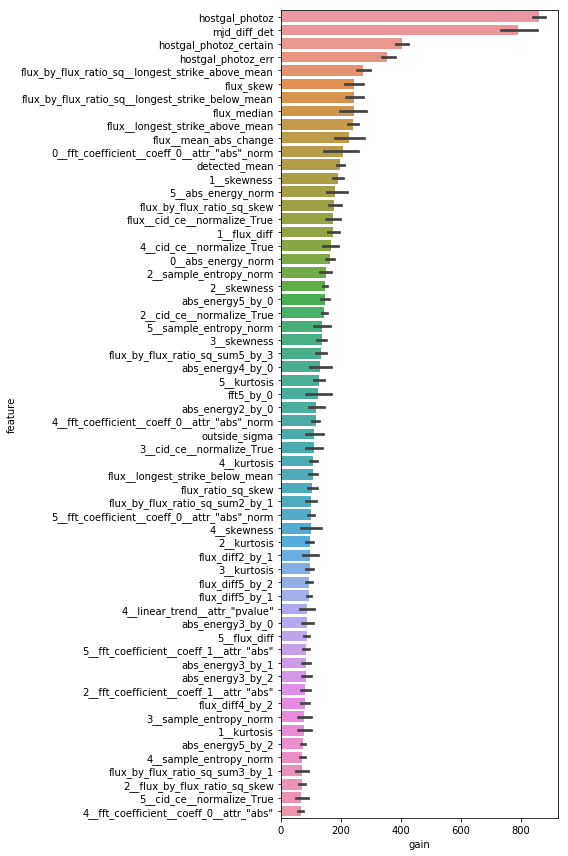

In [49]:
clfs, score, oof_df = lgbm_modeling_cross_validation(
    best_params, 
    full, 
    y, 
    classes,
    class_weight,
    5,
    7)

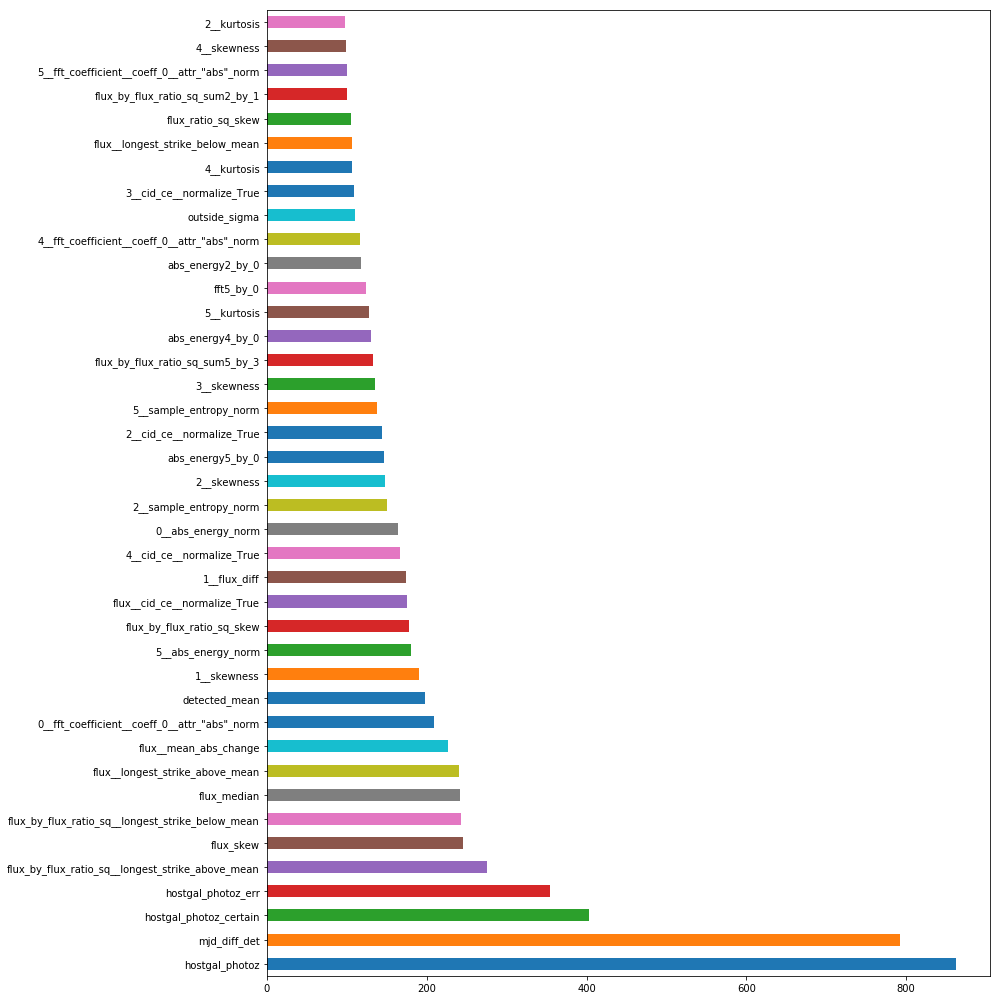

In [56]:
importances = plot_importances(clfs, full.columns)

0.06141059344870652
Normalized confusion matrix


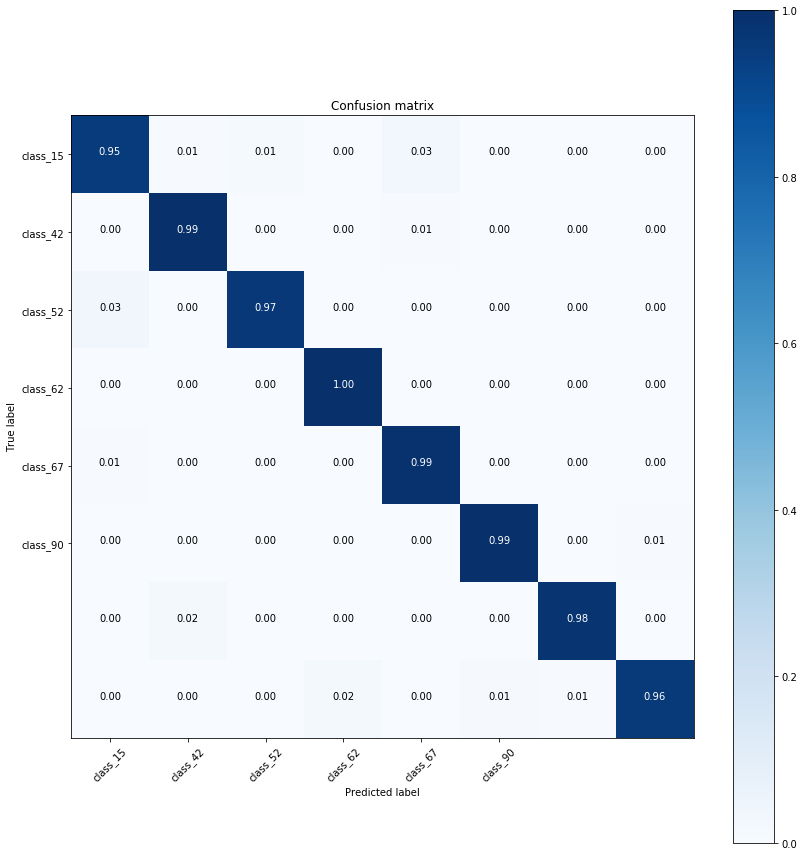

In [53]:
print(score)
save_cm(y, oof_df)

### 特徴量選択

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.0326368	training's wloss: 0.0731817	valid_1's multi_logloss: 0.21649	valid_1's wloss: 0.143733
[200]	training's multi_logloss: 0.00492372	training's wloss: 0.0145066	valid_1's multi_logloss: 0.0789404	valid_1's wloss: 0.0596491
[300]	training's multi_logloss: 0.00234572	training's wloss: 0.00744733	valid_1's multi_logloss: 0.0554084	valid_1's wloss: 0.0492084
[400]	training's multi_logloss: 0.00173315	training's wloss: 0.0056054	valid_1's multi_logloss: 0.048018	valid_1's wloss: 0.0473575
Early stopping, best iteration is:
[407]	training's multi_logloss: 0.00170948	training's wloss: 0.00553887	valid_1's multi_logloss: 0.0477725	valid_1's wloss: 0.0471759
no 1-fold loss: 0.04717592828936081
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.0327146	training's wloss: 0.0739759	valid_1's multi_logloss: 0.2017	valid_1's wloss: 0.162752
[200]	training'

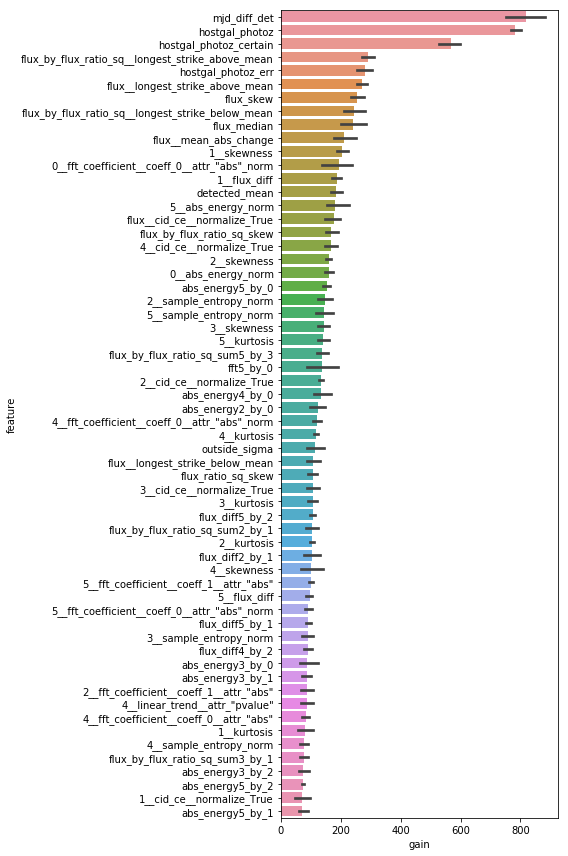

In [70]:
n_drop = 80
features = importances.iloc[:-80].index.tolist()
clfs, score, oof_df = lgbm_modeling_cross_validation(
    best_params, 
    full[features], 
    y, 
    classes,
    class_weight,
    5,
    7)

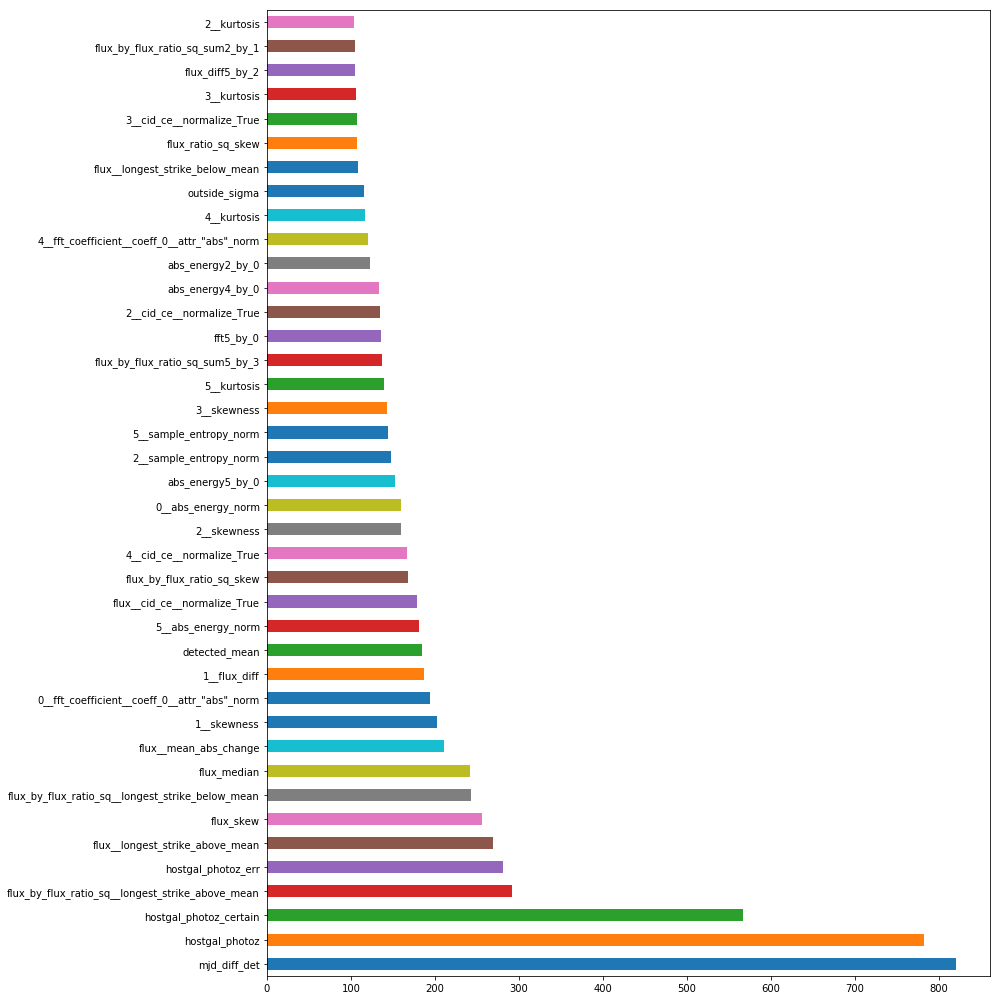

In [71]:
best_importances = plot_importances(clfs, full[features].columns)

0.059968872392239136
Normalized confusion matrix


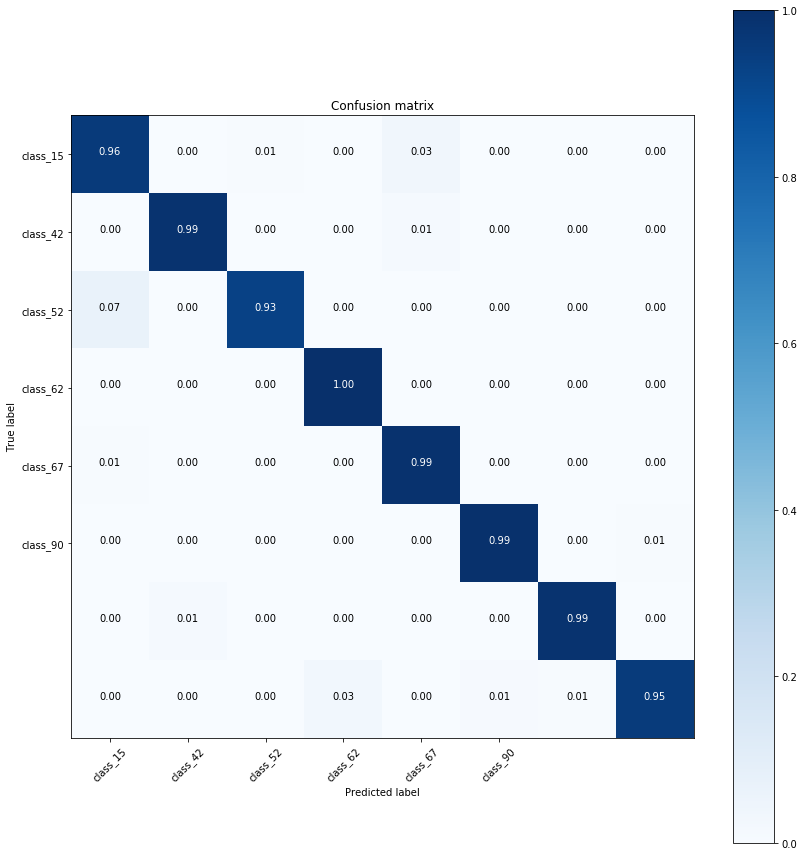

In [72]:
# 0 0.06141059344870652
# 60 0.06280039118432103
# 70 0.06117618124245805
# 80 0.059968872392239136
# 90 0.0629890497566356
# 100 0.06976749330368254

print(score)
save_cm(y, oof_df)

In [76]:
importances.iloc[:-n_drop].to_csv('./non_novae_use_features_ver{}.csv'.format(ver))